# Постановка задачи, описание данных


**Постановка задачи**  
Федеральному оператору сотовой связи "Мегалайн" необходимо понять, какой из двух тарифных планов: «Смарт» и «Ультра» приносит больше денег.  
Компания предоставила данные 500 пользователей.  
Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов** 
  
**Тариф «Смарт»**  
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 3 рубля  
сообщение: 3 рубля  
1 Гб интернет-трафика: 200 рублей  
  
**Тариф «Ультра»**  
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 1 рубль  
сообщение: 1 рубль  
1 Гб интернет-трафика: 150 рублей  

**Описание данных:**  

*Таблица users (информация о пользователях):*  

user_id — уникальный идентификатор пользователя  
first_name — имя пользователя  
last_name — фамилия пользователя  
age — возраст пользователя (годы)  
reg_date — дата подключения тарифа (день, месяц, год)  
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
city — город проживания пользователя  
tariff — название тарифного плана  

*Таблица calls (информация о звонках):* 
  
id — уникальный номер звонка  
call_date — дата звонка  
duration — длительность звонка в минутах  
user_id — идентификатор пользователя, сделавшего звонок    

*Таблица messages (информация о сообщениях):*  

id — уникальный номер сообщения  
message_date — дата сообщения  
user_id — идентификатор пользователя, отправившего сообщение  
  
*Таблица internet (информация об интернет-сессиях):*  
  
id — уникальный номер сессии  
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)  
session_date — дата интернет-сессии  
user_id — идентификатор пользователя  
  
*Таблица tariffs (информация о тарифах):*  
  
tariff_name — название тарифа  
rub_monthly_fee — ежемесячная абонентская плата в рублях  
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату  
messages_included — количество сообщений в месяц, включённых в абонентскую плату  
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
rub_per_message — стоимость отправки сообщения сверх тарифного пакета  
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  


## Выгрузка таблиц

Импортируем нужные библиотеки, загрузим данные

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import math
import seaborn as sns
plt.style.use('ggplot')
sns.set_palette('bright') 
import warnings

warnings.filterwarnings('ignore')

try:
    calls, internet, messages, tariffs, users =(
    pd.read_csv(r'C:\datasets\calls.csv') # звонки
    ,pd.read_csv(r'C:\datasets\internet.csv') # интернет-сессии
    ,pd.read_csv(r'C:\datasets\messages.csv') # сообщения
    ,pd.read_csv(r'C:\datasets\tariffs.csv') # тарифы   
    ,pd.read_csv(r'C:\datasets\users.csv') # пользователи    
)
except:
    calls, internet, messages, tariffs, users =(
    pd.read_csv('/datasets/calls.csv') 
    ,pd.read_csv('/datasets/internet.csv') 
    ,pd.read_csv('/datasets/messages.csv')
    ,pd.read_csv('/datasets/tariffs.csv') 
    ,pd.read_csv('/datasets/users.csv')   
)
   #ознакомимся с таблицами и проверим тип данных
calls.info()
internet.info()
messages.info()
tariffs.info()
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 co

## Обработка типов данных

Замечено, что пропуски присутствуют в таблице users в данных о дате прекращения пользования тарифом.  
Отсутствующие значения связаны с тем, что пользователь еще не прекратил пользование тарифом.  
Приведем имеющиеся данные о дате в корректный формат даты.

In [2]:
users['churn_date']=pd.to_datetime(
    users['churn_date'], format='%Y-%m-%d'
)

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    object        
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


Кроме того, замечено, что все тарифы с датой и временем записаны некорректным типом данных.  


In [4]:
#изменим тип данных на datetime 
for table,row in zip([users, calls, internet, messages], ['reg_date', 'call_date', 'session_date', 'message_date']):
    table[row]=pd.to_datetime(
    table[row], format='%Y-%m-%d'
    )


## Обработка ошибок в данных

В таблице с данными о пользователях присутвует лишний столбец с индексами, уберем его.

In [5]:
internet=internet.drop(columns='Unnamed: 0')

In [6]:
#рассмотрим еще раз имеющиеся таблицы
display(internet.head())
display(calls.head())
display(users.head())
display(messages.head())
display(tariffs.head())

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


**Вывод:**   
Наименования, типы данных, регистры все корректно. 
Возможно, далее при более детальном изучении данных будут найдены ошибки, которые необходимо будет исправить.  


## Рассчеты для анализа

### Количество звонков и израсходованных минут разговора по месяцам

In [7]:
#создадим столбец с месяцем, в который был совершен звонок
calls['call_date_month']=calls['call_date'].dt.month
calls.head()

,id,call_date,duration,user_id,call_date_month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


In [8]:
#согласно условию округлим минуты "вверх"
calls['duration']=calls['duration'].apply(lambda x: math.ceil(x))

In [9]:
#выделяем количество звонков и минут разговора по месяцам
table_calls=pd.pivot_table(calls, 
                     index=['call_date_month', 'user_id'], 
                     values=['id','duration'],
                     aggfunc={'id': 'count',
                             'duration': 'sum'}).reset_index()
table_calls.columns=['month', 'user_id', 'minutes_all', 'count_calls']
table_calls.head()

,month,user_id,minutes_all,count_calls
0,1,1005,95,15
1,1,1032,380,61
2,1,1045,9,1
3,1,1055,551,64
4,1,1071,194,24


### Количество отправленных сообщений по месяцам

In [10]:
#создадим столбец с месяцем, в который было отправлено сообщение
messages['message_date_month']=messages['message_date'].dt.month
messages.head()

,id,message_date,user_id,message_date_month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [11]:
table_messages=messages.groupby(['message_date_month','user_id'])['id'].count().reset_index()
table_messages.columns=['month', 'user_id', 'count_message']
table_messages.head()

,month,user_id,count_message
0,1,1005,7
1,1,1032,38
2,1,1045,5
3,1,1055,30
4,1,1071,16


### Объем израсходованного интернет-трафика по месяцам


In [12]:
#создадим столбец с месяцем, в который была сессия
internet['session_date_month']=internet['session_date'].dt.month
internet.head()

,id,mb_used,session_date,user_id,session_date_month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


In [13]:
table_internet=internet.groupby(['session_date_month', 'user_id'])['mb_used'].sum().reset_index()
table_internet.columns=['month','user_id', 'volume_session']
table_internet.head()

,month,user_id,volume_session
0,1,1005,2727.97
1,1,1032,24127.69
2,1,1045,2346.71
3,1,1055,17090.88
4,1,1071,15604.34


### Помесячная выручка каждого пользователя

In [14]:
table=pd.merge(table_calls,table_messages, how='outer', on=['user_id','month']).merge(table_internet, how='outer', on=['user_id','month'])
table.info()
table.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   month           3214 non-null   int64  
 1   user_id         3214 non-null   int64  
 2   minutes_all     3174 non-null   float64
 3   count_calls     3174 non-null   float64
 4   count_message   2717 non-null   float64
 5   volume_session  3203 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


,month,user_id,minutes_all,count_calls,count_message,volume_session
0,1,1005,95.0,15.0,7.0,2727.97
1,1,1032,380.0,61.0,38.0,24127.69
2,1,1045,9.0,1.0,5.0,2346.71
3,1,1055,551.0,64.0,30.0,17090.88
4,1,1071,194.0,24.0,16.0,15604.34


In [15]:
#изучим данные о звонках с пропусками
table[table['minutes_all'].isna()]
#пример пользователя
table.query('user_id==1106')

,month,user_id,minutes_all,count_calls,count_message,volume_session
3174,4,1106,NaN,NaN,9.0,2923.49
3176,5,1106,NaN,NaN,28.0,16573.01
3179,6,1106,NaN,NaN,30.0,20016.74
3183,7,1106,NaN,NaN,24.0,21626.86
3186,8,1106,NaN,NaN,25.0,19088.67
3191,9,1106,NaN,NaN,23.0,21934.03
3196,10,1106,NaN,NaN,33.0,14010.32
3202,11,1106,NaN,NaN,29.0,21289.27
3208,12,1106,NaN,NaN,24.0,18701.51


Некоторые пользователи пользовались только одной услугой в месяце, заменим пропуски, нулевыми значениями, чтобы не потерять данные.

In [16]:
#изучим данные о смс с пропусками
table[table['count_message'].isna()]

,month,user_id,minutes_all,count_calls,count_message,volume_session
6,1,1120,55.0,5.0,NaN,656.75
15,1,1204,305.0,50.0,NaN,15829.77
19,1,1254,466.0,59.0,NaN,19685.01
25,1,1340,25.0,5.0,NaN,2207.26
37,1,1429,70.0,10.0,NaN,2147.23
...,...,...,...,...,...,...
3144,12,1466,659.0,82.0,NaN,14626.91
3147,12,1469,635.0,106.0,NaN,27762.83
3156,12,1479,576.0,81.0,NaN,23425.98
3169,12,1494,418.0,62.0,NaN,17621.21


Сообщениями, действительно, не так часто пользуются, пропусков большое количесвто, заменим пропуски на ноль.

In [17]:
table=table.fillna(0)
table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   month           3214 non-null   int64  
 1   user_id         3214 non-null   int64  
 2   minutes_all     3214 non-null   float64
 3   count_calls     3214 non-null   float64
 4   count_message   3214 non-null   float64
 5   volume_session  3214 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


In [18]:
#Создадим таблицу, в которой будут присутсвовать данные для расчета помесячной выручки.
table_income=users.merge(table, how='left', on=['user_id'])


In [19]:
table_income.info()
table_income.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3216 non-null   int64         
 1   age             3216 non-null   int64         
 2   churn_date      189 non-null    datetime64[ns]
 3   city            3216 non-null   object        
 4   first_name      3216 non-null   object        
 5   last_name       3216 non-null   object        
 6   reg_date        3216 non-null   datetime64[ns]
 7   tariff          3216 non-null   object        
 8   month           3214 non-null   float64       
 9   minutes_all     3214 non-null   float64       
 10  count_calls     3214 non-null   float64       
 11  count_message   3214 non-null   float64       
 12  volume_session  3214 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(2), object(4)
memory usage: 351.8+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,minutes_all,count_calls,count_message,volume_session
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,159.0,22.0,22.0,2253.49
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,172.0,43.0,60.0,23233.77
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,340.0,47.0,75.0,14003.64
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,408.0,52.0,81.0,14055.93
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,466.0,58.0,57.0,14568.91


In [20]:
#изучим данные с пропусками
table_income[table_income['minutes_all'].isna()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,minutes_all,count_calls,count_message,volume_session
827,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,NaN,NaN,NaN,NaN,NaN
2335,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,NaN,NaN,NaN,NaN,NaN


Всего двое пользователей, которые аероятнее всего, еще не успели воспользоваться услугами, дата регистрации декабрь 2018.  
В дальнейшем будем рассматривать таблицу без этих пользователей.

In [21]:
table_income=table_income.query('user_id !=[1128,1371]')

In [22]:
table_income[['month','minutes_all','count_calls']]=table_income[['month','minutes_all','count_calls']].fillna(0)
table_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3215
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3214 non-null   int64         
 1   age             3214 non-null   int64         
 2   churn_date      187 non-null    datetime64[ns]
 3   city            3214 non-null   object        
 4   first_name      3214 non-null   object        
 5   last_name       3214 non-null   object        
 6   reg_date        3214 non-null   datetime64[ns]
 7   tariff          3214 non-null   object        
 8   month           3214 non-null   float64       
 9   minutes_all     3214 non-null   float64       
 10  count_calls     3214 non-null   float64       
 11  count_message   3214 non-null   float64       
 12  volume_session  3214 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(2), object(4)
memory usage: 351.5+ KB


In [23]:
#создадим функцию, которая будет построчно находить необходимые значения в таблице, вычислять выручку сверх тарифа и складывать
def income_tariff(row):

    """
Функция предполает два вариант рассчета, в соответствии из тарифа пользователя.  
К основной оплате тарифа за месяц прибавляются оплаты сверх тарифа.  
Проверяются условия о количестве звонков, сообщений, трафика.  
Все округления проходят согласно документации в большую сторону, если это 1,0009 ГБ, то в расчет берем 2 ГБ (также с минутами)
"""
    if row['tariff']=='ultra':
        row['income_tariff']=1950
        if 3000-row['minutes_all']<0: #проверка минут(вышел ли пользователь за рамки пакета тарифа)
            row['income_tariff']+=(math.ceil(row['minutes_all'])-3000)*1 #сколько заплатил пользователь, если потратил больше, чем в тарифе
        if 1000-row['count_message']<0: #проверка кол-ва сообщений
            row['income_tariff']+=(row['count_message']-1000)*1
        if 30-math.ceil(row['volume_session']/1024)<0:  #проверка ГБ
            row['income_tariff']+= (math.ceil(row['volume_session']/1024)-30)*150
        return row['income_tariff']
    elif row['tariff']=='smart':
        row['income_tariff']=550
        if 500-row['minutes_all']<0:
            row['income_tariff']+=(math.ceil(row['minutes_all'])-500)*3
        if 50-row['count_message']<0:
            row['income_tariff']+=(row['count_message']-50)*3
        if 15-math.ceil(row['volume_session']/1024)<0:
            row['income_tariff']+= (math.ceil(row['volume_session']/1024)-15)*200
        return row['income_tariff']


table_income['income']=table_income.apply(income_tariff, axis=1) 
table_income.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,minutes_all,count_calls,count_message,volume_session,income
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,159.0,22.0,22.0,2253.49,1950.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,172.0,43.0,60.0,23233.77,1950.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,340.0,47.0,75.0,14003.64,1950.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,408.0,52.0,81.0,14055.93,1950.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,466.0,58.0,57.0,14568.91,1950.0


In [24]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [25]:
tariffs.query('tariff_name == "ultra"')['rub_monthly_fee']

1    1950
Name: rub_monthly_fee, dtype: int64

In [26]:
# Изменим на целочисленный тип данные в месяце, кол-ве сообщений, помесячную прибль пользователя
table_income[['month','count_calls','count_message','income']]=table_income[['month','count_calls','count_message','income']].astype('int')


## Анализ данных

Разделим пользователей на две таблицы ultra и smart.  
Данные возьмем из таблицы с расчетами прибыли.  
Найдем стандарное отклонение, дисперсию, среднее, посроим графики. 

In [27]:
#через срез получаем таблицы 
ultra=table_income.query('tariff=="ultra"')

smart=table_income.query('tariff=="smart"')


### Анализ пользователей тарифа "Ультра"

In [28]:
#Изучим среднее значение
ultra_mean_call=ultra['minutes_all'].mean()
ultra_mean_message=ultra['count_message'].mean()
ultra_mean_session=math.ceil(ultra['volume_session'].mean()/1024)

print(f'Среднее количество минут, которое тратят на разговоры пользователи тарифа "Ультра" : {round(ultra_mean_call,2)}')
print(f'Среднее количество сообщений, которое тратят на отправку пользователи тарифа "Ультра" : {round(ultra_mean_message,2)}')
print(f'Среднее количество интернет-трафика, которое тратят пользователи тарифа "Ультра" : {round(ultra_mean_session,2)}')

Среднее количество минут, которое тратят на разговоры пользователи тарифа "Ультра" : 526.62
Среднее количество сообщений, которое тратят на отправку пользователи тарифа "Ультра" : 49.36
Среднее количество интернет-трафика, которое тратят пользователи тарифа "Ультра" : 20


**Вывод:**  
Если оценивать по среднему значению пользователей, тарифа "Ультра", то можно сказать, что в предоставленном пакете услуг количество минут, сообщений, ГБ предлагается с избытком, пользователи осваивают более 50% пакета только в интренет-трафике.  


Изучим дисперсию, оценивать поведение клиентов будем исходя из выборочных данных, поэтому в методе var применяем параметр ddof.


In [29]:
#Изучим дисперсию

ultra_var_call=np.var(ultra['minutes_all'], ddof=1)
ultra_var_message=np.var(ultra['count_message'], ddof=1)
ultra_var_session=np.var(ultra['volume_session'], ddof=1)

print(f'Дисперсия минут, пользователей тарифа "Ультра" : {round(ultra_var_call,2)}')
print(f'Дисперсия сообщений, пользователей тарифа "Ультра" : {round(ultra_var_message,2)}')
print(f'Дисперсия интернет-трафика, пользователей тарифа "Ультра" : {round((ultra_var_session/1024),2)}')

Дисперсия минут, пользователей тарифа "Ультра" : 100873.63
Дисперсия сообщений, пользователей тарифа "Ультра" : 2285.27
Дисперсия интернет-трафика, пользователей тарифа "Ультра" : 99366.22


**Вывод:**  делать вывод об использовании возможностей тарифа на основании дисперсии не совсем корректно, т.к. данные представленны в квадратных единицах.

In [30]:
#Изучим стандартное отклонение

ultra_std_call=np.std(ultra['minutes_all'], ddof=1)
ultra_std_message=np.std(ultra['count_message'], ddof=1)
ultra_std_session=np.std(ultra['volume_session'], ddof=1)

print(f'Стандартное отклонение минут, пользователей тарифа "Ультра" : {round(ultra_std_call,2)}')
print(f'Стандартное отклонение сообщений, пользователей тарифа "Ультра" : {round(ultra_std_message,2)}')
print(f'Стандартное отклонение интернет-трафика, пользователей тарифа "Ультра" : {round(math.ceil(ultra_std_session/1024),2)}')

Стандартное отклонение минут, пользователей тарифа "Ультра" : 317.61
Стандартное отклонение сообщений, пользователей тарифа "Ультра" : 47.8
Стандартное отклонение интернет-трафика, пользователей тарифа "Ультра" : 10


**Вывод:**  
Разброс данных о минутах, сообщениях, интернет-трафике от их среднего значения не выходит за рамки предлагаемого тарифом "Ультра" пакета минут, сообщений, ГБ.

Визуализируем данные в график оценки одномерного распределения по выборке

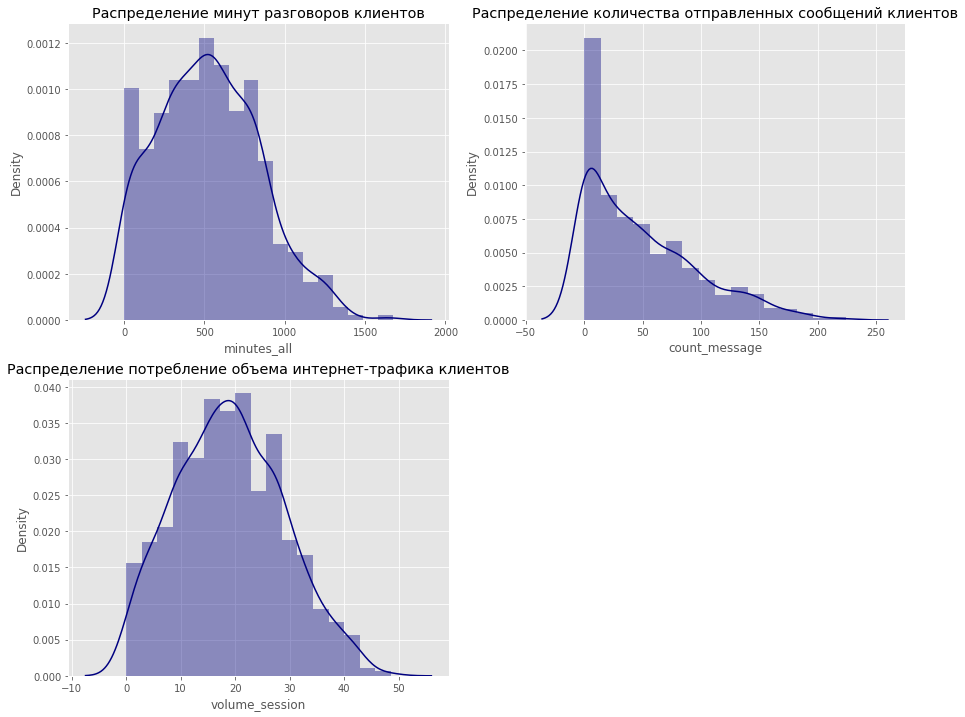

In [31]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.title("Распределение минут разговоров клиентов")
sns_plot = sns.distplot(ultra['minutes_all'], color='Navy')

plt.subplot(2, 2, 2)
plt.title("Распределение количества отправленных сообщений клиентов")
sns_plot = sns.distplot(ultra['count_message'], color='Navy')

plt.subplot(2, 2, 3)
plt.title("Распределение потребление объема интернет-трафика клиентов")
sns_plot = sns.distplot(ultra['volume_session']/1024, color='Navy')

**Вывод:** исходя из представленных диаграмм можно сказать, что данные о минутах и интернет-трафике имеют небольшую положительную скошенность.  
Что касатеся данных о количестве сообщений, то они отрицательно скошены, распределение ненормальное. 
Также можно заметить, что в звонках присутсвуют выбросы, что может влиять на показатель среднего значения.  
Можно сказать, что пользователи тарифа "Ультра" из предложенного пакета услуг осваивают только интернет-трафик.  
Минутами и сообщениями пользуются вдвое меньше, чем предлагает им пакет тарифа.

### Анализ пользователей тарифа "Смарт"

In [32]:
#Изучим среднее значение
smart_mean_call=smart['minutes_all'].mean()
smart_mean_message=smart['count_message'].mean()
smart_mean_session=math.ceil(smart['volume_session'].mean()/1024)

print(f'Среднее количество минут, которое тратят на разговоры пользователи тарифа "Смарт" : {round(smart_mean_call,2)}')
print(f'Среднее количество сообщений, которое тратят на отправку пользователи тарифа "Смарт" : {round(smart_mean_message,2)}')
print(f'Среднее количество интернет-трафика, которое тратят пользователи тарифа "Смарт": {round(smart_mean_session,2)}')

Среднее количество минут, которое тратят на разговоры пользователи тарифа "Смарт" : 417.93
Среднее количество сообщений, которое тратят на отправку пользователи тарифа "Смарт" : 33.38
Среднее количество интернет-трафика, которое тратят пользователи тарифа "Смарт": 16


**Вывод:**  
Исходя из показателей среднего значения, видно, что клиентам не хватет интернет-трафика. 


In [33]:
#Изучим дисперсию

smart_var_call=np.var(smart['minutes_all'], ddof=1)
smart_var_message=np.var(smart['count_message'], ddof=1)
smart_var_session=np.var(smart['volume_session'], ddof=1)

print(f'Дисперсия минут, пользователей тарифа "Смарт" : {round(smart_var_call,2)}')
print(f'Дисперсия сообщений, пользователей тарифа "Смарт" : {round(smart_var_message,2)}')
print(f'Дисперсия интернет-трафика, пользователей тарифа "Смарт" : {round(smart_var_session,2)}')

Дисперсия минут, пользователей тарифа "Смарт" : 36219.32
Дисперсия сообщений, пользователей тарифа "Смарт" : 796.81
Дисперсия интернет-трафика, пользователей тарифа "Смарт" : 34462496.46


**Вывод:**  
делать вывод об использовании возможностей тарифа на основании дисперсии не совсем корректно, т.к. данные представленны в квадратных единицах.

In [34]:
#Изучим стандартное отклонение

smart_std_call=np.std(smart['minutes_all'], ddof=1)
smart_std_message=np.std(smart['count_message'], ddof=1)
smart_std_session=np.std(smart['volume_session'], ddof=1)

print(f'Стандартное отклонение минут, пользователей тарифа "Смарт" : {round(smart_std_call,2)}')
print(f'Стандартное отклонение сообщений, пользователей тарифа "Смарт" : {round(smart_std_message,2)}')
print(f'Стандартное отклонение интернет-трафика, пользователей тарифа "Смарт" : {round(math.ceil(smart_std_session/1024),2)}')

Стандартное отклонение минут, пользователей тарифа "Смарт" : 190.31
Стандартное отклонение сообщений, пользователей тарифа "Смарт" : 28.23
Стандартное отклонение интернет-трафика, пользователей тарифа "Смарт" : 6


**Вывод:**  
Разброс данных о минутах и интернет-трафика от их среднего значения выходит за рамки предлагаемого тарифом "Смарт" пакета минут и ГБ.  
Что касается сообщений, то данные показывают, что разброс данных от среднего показателя входит в границы пакета, в количество 50 сообщений.

Построим визуализацию данных тарифа "Смарт"

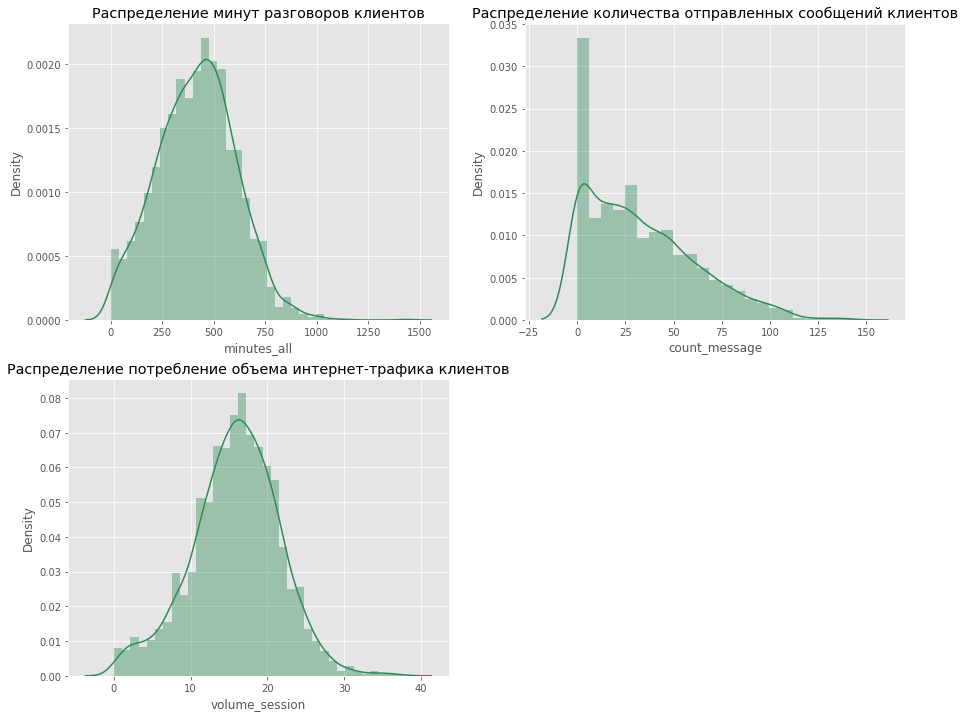

In [35]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.title("Распределение минут разговоров клиентов")
sns_plot = sns.distplot(smart['minutes_all'], color='SeaGreen')

plt.subplot(2, 2, 2)
plt.title("Распределение количества отправленных сообщений клиентов")
sns_plot = sns.distplot(smart['count_message'], color='SeaGreen')

plt.subplot(2, 2, 3)
plt.title("Распределение потребление объема интернет-трафика клиентов")
sns_plot = sns.distplot(smart['volume_session']/1024, color='SeaGreen')

**Вывод:** исходя из представленных диаграмм можно сказать, что данные о звонках имеют небольшую положительную скошенность.  
Что касатеся данных о количестве сообщений, то они отрицательно скошены, распределение ненормальное.  
Интернет-трафик осваивается полностью, даже можно заметить небольшие выбросы.
Также можно заметить, что в звонках присутсвуют выбросы, что может влиять на показатель среднего значения.  
Можно сказать, что пользователи тарифа "Смарт" из предложенного пакета услуг оставивают практически полностью минуты и интернет-трафик.  
Сообщениями пользуются вдвое меньше, чем предлагает им пакет тарифа.

## Формулировка и проверка гипотез

**Формулировка гипотезы:**  
Н1_0 средняя выручка пользователей тарифов «Ультра» и «Смарт» равны
Н1_1 средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны

Н2_0 средняя выручка пользователей из Москвы равна выручки пользователей из других регионов
Н2_1 средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

### Н1 средняя выручка пользователей тарифов «Ультра» и «Смарт» равны

In [36]:
print('Среднее значение выручки клиентов "Ультра":', round(ultra['income'].mean(),2))
print('Среднее значение выручки клиентов "Смарт":', round(smart['income'].mean(),2))

Среднее значение выручки клиентов "Ультра": 2070.15
Среднее значение выручки клиентов "Смарт": 1289.97


In [37]:
#исследуем вероятность H1

alpha = .01 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
    ultra['income'], 
    smart['income'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу Н1_0")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 


p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу Н1_0


**Вывод:**  
Отвергаем Н1_0 (средняя выручка пользователей тарифов «Ультра» и «Смарт» равны) и принимаем гипотезу Н1_1 (средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны).  


### Средняя выручка пользователей из Москвы равна выручки пользователей из других регионов

In [38]:
mean_msk=table_income.query('city=="Москва"')['income'].mean()
mean_region=table_income.query('city!="Москва"')['income'].mean()

print('Среднее значение выручки клиентов из Москвы:', round(mean_msk,2))
print('Среднее значение выручки клиентов из регионов:', round(mean_region,2))

Среднее значение выручки клиентов из Москвы: 1546.71
Среднее значение выручки клиентов из регионов: 1524.94


In [39]:
#исследуем вероятность H2

alpha = .01 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
    table_income.query('city=="Москва"')['income'], 
    table_income.query('city!="Москва"')['income'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу Н1_0")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


**Вывод:**  
По результатам t-теста вероятность нулевой гипотезы выше 40%, поэтому нулевую гипотезу отвергнуть не удалось, остаемся в рамках нулевой гипотезы.

## Общий вывод

На основании проведенного анализа и предоставленных данных о 500 пользователей тарифами оператора сотовой связи "Мегалайн" можно сказать, что тариф "Ультра" приносит больше средств, чем тариф "Смарт".  

Рекомендации:  
- В тарифе "Ультра" остается большое количество не освоеных минут и сообщений, возможно, стоит сделать пакет услуг более клиентоориентированным
- В тарифе "Смарт" интренет-трафика клиентам едва хватает, а сообщений с избытком